# Notebook to experiment with training:

## Code:

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class Glioblastoma(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4} 
    # The metadata of the environment, e.g. {“render_modes”: [“rgb_array”, “human”], “render_fps”: 30}. 
    # For Jax or Torch, this can be indicated to users with “jax”=True or “torch”=True.

    def __init__(self, image_path, mask_path, grid_size=4, tumor_threshold=0.15, render_mode="human"): # cosntructor with the brain image, the mask and a size
        super().__init__() # parent class
        
        self.image = np.load(image_path).astype(np.float32)
        self.mask = np.load(mask_path).astype(np.uint8)
        
        img_min, img_max = self.image.min(), self.image.max()
        if img_max > 1.0:  # only normalize if not already in [0, 1]
            self.image = (self.image - img_min) / (img_max - img_min + 1e-8) #avoid division by 0

        self.grid_size = grid_size
        self.block_size = self.image.shape[0] // grid_size  # 240/4 = 60
        self.render_mode = render_mode

        # Define action and observation spaces
        # Actions: 0 = stay, 1 = move down, 2 = move right
        self.action_space = spaces.Discrete(3)

        # Observations: grayscale patch (normalized 0-1)
        # apparently Neural networks train better when inputs are scaled to small, 
        # consistent ranges rather than raw 0–255 values.
        self.observation_space = spaces.Box( # Supports continuous (and discrete) vectors or matrices
            low=0, high=1, # Data has been normalized
            shape=(self.block_size, self.block_size), # shape of the observation
            dtype=np.float32
        )

        self.agent_pos = [0, 0] # INITIAL POSITION AT TOP LEFT
        self.current_step = 0 # initialize counter
        self.max_steps = 20  # like in the paper

        self.tumor_threshold = tumor_threshold # 15% of the patch must be tumor to consider that the agent is inside the tumor region

    def reset(self, seed=None, options=None): # new episode where we initialize the state. 
        super().reset(seed=seed) # parent
        
        # reset
        self.agent_pos = [0, 0]  # top-left corner
        self.current_step = 0
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1

        prev_pos = self.agent_pos.copy() # for reward computation taking into consideration the transition changes
        
        # Apply action (respect grid boundaries)
        if action == 1 and self.agent_pos[0] < self.grid_size - 1:
            self.agent_pos[0] += 1  # move down
        elif action == 2 and self.agent_pos[1] < self.grid_size - 1:
            self.agent_pos[1] += 1  # move right
        # else, the agent doesn't move so the observation 
        # and reward will be calculated from the same position
        # no need to compute self.agent_po

        reward = self._get_reward(action, prev_pos)
        obs = self._get_obs()

        # Episode ends
        terminated = self.current_step >= self.max_steps
        truncated = False  # we don’t need truncation here
        info = {}

        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        r0 = self.agent_pos[0] * self.block_size # row start
        c0 = self.agent_pos[1] * self.block_size # col start
        
        patch = self.image[r0:r0+self.block_size, c0:c0+self.block_size]
        return patch.astype(np.float32) #just to ensure everything is float32

    def _get_reward(self, action, prev_pos):
        # look for previous position in the mask
        r0_prev = prev_pos[0] * self.block_size
        c0_prev = prev_pos[1] * self.block_size
        patch_mask_prev = self.mask[r0_prev:r0_prev+self.block_size, c0_prev:c0_prev+self.block_size]
        
        # look position of the agent in the mask
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        patch_mask = self.mask[r0:r0+self.block_size, c0:c0+self.block_size]
        
        # Now that i have the patch where i was and the patch where i am, i can check if there is tumor in any of them
        # tumor is labeled as 1 or 4 in the mask        
        # label 2 is edema
        
        # first get a count of the tumor pixels in the patch. 
        tumor_count_prev = np.sum(np.isin(patch_mask_prev, [1, 4]))
        tumor_count_curr = np.sum(np.isin(patch_mask, [1, 4]))

        # Determine if patch has more than self.tumor_threshold of tumor
        was_inside = tumor_count_prev > self.tumor_threshold
        inside = tumor_count_curr > self.tumor_threshold

        # REWARD STRATEGY DELS DEL PAPER FALTA SI AIXO ES AIXI
        if inside: # regardless of previous position
            print("Entered tumor region!") # DEBUGGING ONLY!
            return 1.0  # entered tumor region
        if not was_inside and not inside: # still outside
            if action == 0: # didn't move
                return -2.0
            else:
                return -0.5 # moved but still outside
        if was_inside and not inside: # exited tumor region
            print("Exited tumor region!") # DEBUGGING ONLY!
            return -0.5  # exited tumor region #maybe should be -1.0? FALTAA!!!!!!!!!!!!!!!!!!!
        return 0.0

    def render(self):
        if self.render_mode != "human": # would be rgb_array or ansi
            return  # Only render in human mode

        # Create RGB visualization image
        # not necessary since it's grayscale, but i want to draw the mask and position
        vis_img = np.stack([self.image] * 3, axis=-1).astype(np.float32)

        # Overlay tumor mask in red [..., 0] 
        tumor_overlay = np.zeros_like(vis_img) # do all blank but here we have 3 channels, mask is 2D
        tumor_overlay[..., 0] = (self.mask > 0).astype(float) # red channel. set to float to avoid issues when blending in vis_img

        # transparency overlay (crec que es el mateix valor que tinc a l'altra notebook)
        alpha = 0.4
        vis_img = (1 - alpha) * vis_img + alpha * tumor_overlay

        # Plotting
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(vis_img, cmap='gray', origin='upper')

        # Draw grid lines
        # alpha for transparency again
        for i in range(1, self.grid_size):
            ax.axhline(i * self.block_size, color='white', lw=1, alpha=0.5)
            ax.axvline(i * self.block_size, color='white', lw=1, alpha=0.5)

        # Draw agent position
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        rect = patches.Rectangle(
            (c0, r0), # (x,y) bottom left corner
            self.block_size, # width
            self.block_size, # height
            linewidth=2,
            edgecolor='yellow',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"Agent at {self.agent_pos} | Step {self.current_step}")
        ax.axis('off')
        plt.show()


# DQN:

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [3]:
import torch
from collections import namedtuple, deque
from copy import deepcopy, copy
import wandb
import random
import itertools
import datetime

import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [4]:
trial_image_path = f"/home/martina/codi2/4year/tfg/training_set_npy/001_49.npy"
trial_mask_path = f"/home/martina/codi2/4year/tfg/training_set_npy/001_49_mask.npy"

env = Glioblastoma(trial_image_path, trial_mask_path, grid_size=4)
print(env.observation_space.shape)
print(env.action_space.n)
print(np.arange(env.action_space.n))


(60, 60)
3
[0 1 2]


neural network that approximates the Q-function

In [5]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0] # 60
        self.n_outputs = env.action_space.n # 3
        self.actions = np.arange(env.action_space.n) # np.array([0, 1, 2])
        self.learning_rate = learning_rate
        
        input_channels = 1
        height, width = env.observation_space.shape  # 60, 60   
        
        ### Construction of the neural network
        ## features first and then fully connected layers
        
        # conv2d(in channels, out channels, kernel size, stride, padding)
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
        )
        
        # flatten 
        with  torch.no_grad(): # FALTA MIRAR Q ES AIXO
            dummy_input = torch.zeros(1, input_channels, height, width) # batch size 1
            n_flatten = self.features(dummy_input).view(1, -1).size(1)
            
        # nn.Linear (in features, out features)
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, self.n_outputs)
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        ### Work with CUDA is allowed
        if self.device == 'cuda':
            self.model.cuda()
            
    
    # e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            # random action -- Exploration
            action = np.random.choice(self.actions)  
        else:
            # Q-value based action -- Exploitation
            qvals = self.get_qvals(state)  
            action= torch.max(qvals, dim=-1)[1].item()
        
        return action
    
    # forward pass through conv and fc layers
    def get_qvals(self, state): # FALTAAAAAA
        # Convert (60,60) → (1,1,60,60)
        if isinstance(state, np.ndarray):
            if state.ndim == 2:  # grayscale single image
                state = np.expand_dims(np.expand_dims(state, 0), 0)
            elif state.ndim == 3:  # batch or stacked images
                if state.shape[0] != 1:
                    state = np.expand_dims(state, 1)
        state_t = torch.FloatTensor(state).to(self.device)
        qvals = self.fc(self.features(state_t).view(state_t.size(0), -1))
        return qvals

In [30]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, epsilon_min=0.01, batch_size=32, gamma=0.99):
        self.env = env
        self.dnnetwork = dnnetwork # main network
        self.target_network = deepcopy(dnnetwork) # prevents the target Q-values from changing with every single update
        self.buffer = buffer # store experiences
        self.epsilon = epsilon # initial epsilon for e-greedy
        self.eps_decay = eps_decay # decay of epsilon after each episode to balance exploration and exploitation
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size # size of the mini-batch for training
        self.gamma = gamma
        
        # block of the last X episodes to calculate the average reward 
        self.nblock = 100 
        # average reward used to determine if the agent has learned to play
        #self.reward_threshold = self.env.spec.reward_threshold 
        self.initialize()
    
    def initialize(self): # reset variables at the beginning of training
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    ## Take new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            # random action in burn-in and in the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # Action based on the Q-value (max Q-value)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute action and get reward and new state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        # save experience in the buffer
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = self.env.reset()[0]
        return done

            
    ## Training
    def train(self, gamma=0.99, max_episodes=50000, 
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        #while self.buffer.burn_in_capacity() < 1:
        while len(self.buffer.buffer) < self.batch_size:
            self.take_step(self.epsilon, mode='explore')
            
        # Store metrics locally to plot
        self.episode_rewards = []
        self.mean_rewards = []
        self.epsilon_values = []
        self.loss_values = []
 
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # The agent takes an action
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Upgrade main network
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main network and the target network
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                if gamedone:                   
                    episode += 1
                    # Save the rewards
                    self.training_rewards.append(self.total_reward)
                    # Calculate the average reward for the last X episodes
                    if len(self.training_rewards) >= self.nblock:
                        mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    else:
                        mean_rewards = np.mean(self.training_rewards)  # Use all rewards if less than nblock
                    
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(episode, mean_rewards, self.epsilon), end="")
                    
                    wandb.log({
                        'episode': episode,
                        'mean_rewards': mean_rewards,
                        'episode reward': self.total_reward,
                        'epsilon': self.epsilon,
                        'loss': np.mean(self.update_loss)
                    }, step=episode)
                    
                    # Append metrics to lists for plotting
                    self.episode_rewards.append(self.total_reward)
                    self.mean_rewards.append(mean_rewards)
                    self.epsilon_values.append(self.epsilon)
                    self.loss_values.append(np.mean(self.update_loss))
                    
                    self.update_loss = []

                    # Check if there are still episodes left
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # # The game ends if the average reward has reached the threshold
                    # if mean_rewards >= self.reward_threshold:
                    #     training = False
                    #     print('\nEnvironment solved in {} episodes!'.format(episode))
                    #     break
                    
                    # Update epsilon according to the fixed decay rate # SUBTRACTION FROM PPAPER
                    self.epsilon = max(self.epsilon - self.eps_decay, self.epsilon_min)
                    torch.save(self.dnnetwork.state_dict(), "Glioblastoma" + ".dat")
                    
        # PLOTTING
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
        axes = axes.ravel()  # Flatten the axes array for easier indexing

        # Plot episode rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Episode Rewards Over Time')

        # Plot mean rewards
        axes[1].plot(self.mean_rewards)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Mean Reward')
        axes[1].set_title('Mean Rewards Over Time')

        # Plot epsilon values
        axes[2].plot(self.epsilon_values)
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Epsilon Values')
        axes[2].set_title('Epsilon Values Over Time')

        # Plot loss values
        axes[3].plot(self.loss_values)
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Loss')
        axes[3].set_title('Loss Over Time')

        # Adjust layout (optional)
        # fig.suptitle('Training Performance', fontsize=16)  # Add a main title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing between subplots and title
        plt.show()


    # Loss calculation           
    def calculate_loss(self, batch):
        # Separate the variables of the experience and convert them to tensors
        states, actions, rewards, dones, next_states = batch
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device=self.dnnetwork.device)
        dones_t = torch.BoolTensor(dones).to(device=self.dnnetwork.device)
        
        # Obtain the Q values of the main network
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        
        # Obtain the target Q values.
        # The detach() parameter prevents these values from updating the target network
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        # 0 in terminal states
        qvals_next[dones_t] = 0 
        
        # Calculate the Bellman equation
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Calculate the loss
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    def update(self):
        if len(self.buffer.buffer) < self.batch_size:
            return  # skip until we have enough experiences
        
        # Remove any gradient
        self.dnnetwork.optimizer.zero_grad()  
        # Select a subset from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size) 
        # Calculate the loss
        loss = self.calculate_loss(batch) 
        # Difference to get the gradients
        loss.backward() 
        # Apply the gradients to the neural network
        self.dnnetwork.optimizer.step() 
        # Save loss values
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [31]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def append(self, state, action, reward, done, next_state):
        self.buffer.append((state, action, reward, done, next_state))

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, dones, next_states = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
        )

    def burn_in_capacity(self):
        return len(self.buffer) / self.capacity

In [32]:
LR = 0.0001 #From paper
MEMORY_SIZE = 15000 #From paper
MAX_EPISODES = 90 #From paper
EPSILON = 0.7 #From paper
EPSILON_DECAY = 0.0001 #From paper
EPSILON_MIN = 0.0001 #From paper
GAMMA = 0.99
BATCH_SIZE = 128 #From paper
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 100

In [12]:
import glob
import os
import pandas as pd

base_dir = "/home/martina/codi2/4year/tfg/training_set_npy"
csv_path = "/home/martina/codi2/4year/tfg/training_dataset_slices.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Construct image and mask filenames
df["image_path"] = df.apply(
    lambda row: os.path.join(base_dir, f"{row['Patient']:03d}_{row['SliceIndex']}.npy"), axis=1
)
df["mask_path"] = df.apply(
    lambda row: os.path.join(base_dir, f"{row['Patient']:03d}_{row['SliceIndex']}_mask.npy"), axis=1
)

# Sanity check (optional)
train_pairs = [
    (img, mask)
    for img, mask in zip(df["image_path"], df["mask_path"])
    if os.path.exists(img) and os.path.exists(mask)
]

print(f"✅ Found {len(train_pairs)} training pairs out of {len(df)} listed in CSV.")

print(train_pairs[:5])  # Print first 5 pairs to verify


✅ Found 30 training pairs out of 30 listed in CSV.
[('/home/martina/codi2/4year/tfg/training_set_npy/001_49.npy', '/home/martina/codi2/4year/tfg/training_set_npy/001_49_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_npy/003_69.npy', '/home/martina/codi2/4year/tfg/training_set_npy/003_69_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_npy/020_26.npy', '/home/martina/codi2/4year/tfg/training_set_npy/020_26_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_npy/025_109.npy', '/home/martina/codi2/4year/tfg/training_set_npy/025_109_mask.npy'), ('/home/martina/codi2/4year/tfg/training_set_npy/027_61.npy', '/home/martina/codi2/4year/tfg/training_set_npy/027_61_mask.npy')]


In [37]:
net = DQN(Glioblastoma(*train_pairs[0], grid_size=4), learning_rate=LR, device='cpu')
buffer = ReplayBuffer(capacity=MEMORY_SIZE)
agent = DQNAgent(Glioblastoma(*train_pairs[0], grid_size=4), net, buffer,
                 epsilon=EPSILON, eps_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN, batch_size=BATCH_SIZE, gamma=GAMMA)

In [38]:
wandb.login()

wandb.init(project="TFG_Glioblastoma", config={
    "lr": LR,
    "MEMORY_SIZE": MEMORY_SIZE,
    "MAX_EPISODES": MAX_EPISODES,
    "EPSILON": EPSILON,
    "EPSILON_DECAY": EPSILON_DECAY,
    "EPSILON_MIN": EPSILON_MIN,
    "GAMMA": GAMMA,
    "BATCH_SIZE": BATCH_SIZE,
    "BURN_IN": BURN_IN,
    "DNN_UPD": DNN_UPD,
    "DNN_SYNC": DNN_SYNC
})

>>> Training starts at  2025-10-16 00:34:22.829712
Filling replay buffer...
Entered tumor region!
Entered tumor region!
Entered tumor region!
Entered tumor region!
Training...
Entered tumor region!
Entered tumor region!
Entered tumor region!
Exited tumor region!
Episode 1 Mean Rewards -13.00 Epsilon 0.7		Entered tumor region!
Entered tumor region!
Entered tumor region!
Exited tumor region!
Episode 2 Mean Rewards -17.25 Epsilon 0.6999		Entered tumor region!
Entered tumor region!
Entered tumor region!
Exited tumor region!
Entered tumor region!
Exited tumor region!
Episode 3 Mean Rewards -22.33 Epsilon 0.6998		Entered tumor region!
Exited tumor region!
Entered tumor region!
Exited tumor region!
Episode 4 Mean Rewards -24.88 Epsilon 0.6997		Entered tumor region!
Episode 6 Mean Rewards -21.67 Epsilon 0.6995		Entered tumor region!
Exited tumor region!
Episode 7 Mean Rewards -21.21 Epsilon 0.6994		Entered tumor region!
Exited tumor region!
Episode 8 Mean Rewards -20.50 Epsilon 0.6993		Entered

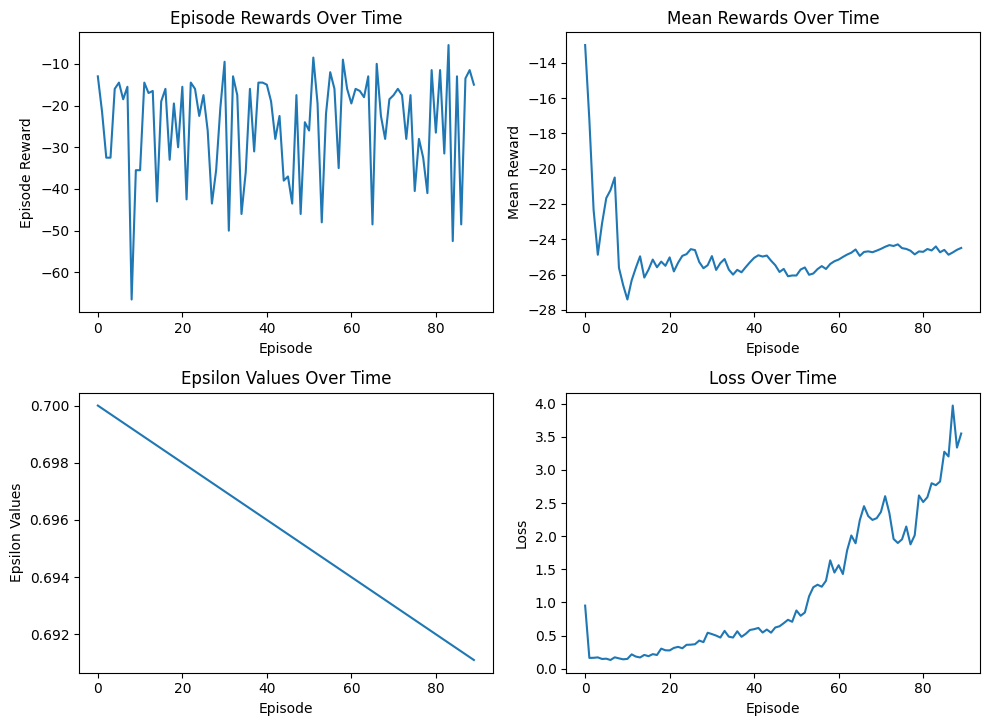

>>> Training completed at  2025-10-16 00:46:59.193727


In [39]:
print(">>> Training starts at ",datetime.datetime.now())

original_take_step = agent.take_step

def take_step_with_random_env(self, eps, mode='train'):
    if self.step_count == 0 or np.random.random() < 0.05:
        img_path, mask_path = random.choice(train_pairs)
        self.env = Glioblastoma(img_path, mask_path, grid_size=4)
        self.state0 = self.env.reset()[0]
    return original_take_step(eps, mode)

agent.take_step = take_step_with_random_env.__get__(agent, DQNAgent)

agent.train(
    max_episodes=MAX_EPISODES,
    dnn_update_frequency=DNN_UPD,
    dnn_sync_frequency=DNN_SYNC
)

torch.save(agent.dnnetwork.state_dict(), "DQN_Glioblastoma_trained.pt")


print(">>> Training completed at ",datetime.datetime.now())

In [36]:
wandb.finish()


In [ ]:
between and after printing statements

for episode in range(MAX_EPISODES):
    # Pick one training image/mask
    img_path, mask_path = random.choice(train_pairs)
    env = Glioblastoma(img_path, mask_path, grid_size=4)
    agent.env = env  # update env

    done = False
    agent.state0 = env.reset()[0]
    agent.total_reward = 0

    while not done:
        done = agent.take_step(agent.epsilon, mode='train')

        # Update Q-network
        if agent.step_count % DNN_UPD == 0:
            agent.update()

        # Sync target network
        if agent.step_count % DNN_SYNC == 0:
            agent.target_network.load_state_dict(agent.dnnetwork.state_dict())

    # Episode complete
    mean_reward = np.mean(agent.training_rewards[-100:]) if agent.training_rewards else agent.total_reward
    print(f"Episode {episode+1}/{MAX_EPISODES} | Reward: {agent.total_reward:.3f} | Mean: {mean_reward:.3f}")

    agent.training_rewards.append(agent.total_reward)
    agent.epsilon = max(agent.epsilon * agent.eps_decay, 0.01)


torch.save(agent.dnnetwork.state_dict(), "DQN_Glioblastoma_trained.pt")
